<h2>Creazione modello SARIMA sul totale dei decessi registrati dall'ISTAT a livello mensile</h2>

<p>Il DataSet utilizzato contiene i dati relativi al totale dei decessi giornalieri rigistrati dall'ISTAT dal <b>1 gennaio 2015 </b> al <b>30 settembre 2020</b>.
    </p>

In [19]:
import pandas as pd
df = pd.read_csv('../csv/serieStorica_decessi_tot.csv')
df.head()

,DATA,TOTALE
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATA    2100 non-null   object
 1   TOTALE  2100 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.9+ KB


In [21]:
df['DATA'] = pd.to_datetime(df['DATA'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    2100 non-null   datetime64[ns]
 1   TOTALE  2100 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 32.9 KB


<h2> Creazione della serie storica mensile</h2>

In [22]:
df=df.set_index('DATA')
df = df.groupby(pd.Grouper(freq='M')).sum()
df

,TOTALE
DATA,
2015-01-31,68514
2015-02-28,61031
2015-03-31,60418
2015-04-30,53591
2015-05-31,50678
...,...
2020-05-31,52102
2020-06-30,48239
2020-07-31,50895


In [23]:
ts = df.TOTALE
ts.head()

DATA
2015-01-31    68514
2015-02-28    61031
2015-03-31    60418
2015-04-30    53591
2015-05-31    50678
Freq: M, Name: TOTALE, dtype: int64

<h2>Visualizzazione della serie storica </h2>

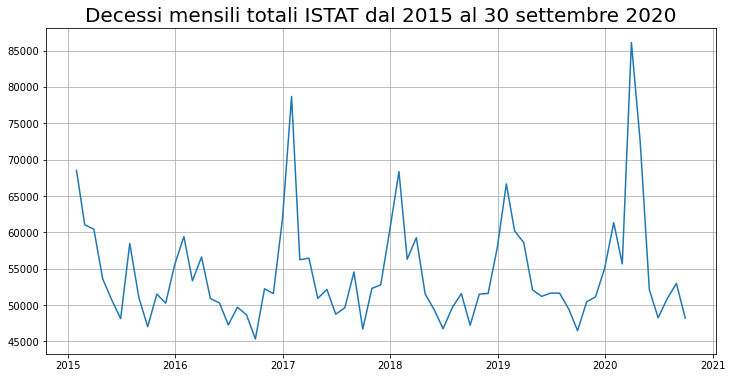

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili totali ISTAT dal 2015 al 30 settembre 2020', size=20)
plt.plot(lim_ts)
plt.grid()

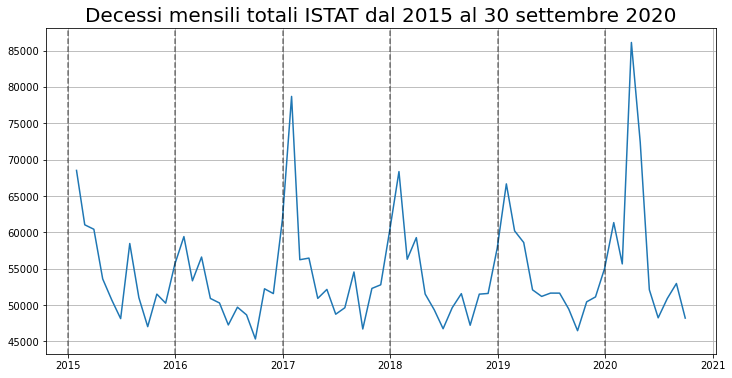

In [25]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,9,30)
lim_ts = ts[start_date:end_date]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili totali ISTAT dal 2015 al 30 settembre 2020', size=20)
plt.plot(lim_ts)
plt.grid()
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h2>Decomposizione </h2>

Attraverso la funzione `seasonal_decompose()` la serie storica viene decomposta in <b>trend</b>, <b>stagionalità</b> e <b>residui</b>. 

Tramite questo processo è possibile visionare più nel dettaglio l'andamento della serie storica esaminata, con lo scopo d'impiegare le informazioni acquisite per la creazione di un valido modello predittivo. 


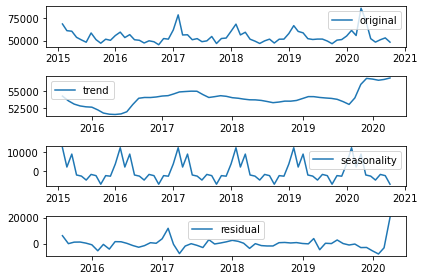

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts)

ts_trend = decomposition.trend 
ts_seasonal = decomposition.seasonal
ts_residual = decomposition.resid
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h2> Test stazionario </h2>

La modellazione di una serie storica è possibile solo se la serie è <b>stazionaria</b>, ovvero quando le sue proprietà statistiche non variano nel tempo.

La funzione `test_stationarity()` verifica che la serie storica sia stazionaria o meno attraverso il calcolo della <b>Rolling Statistic</b> e del <b>Dickey-Fuller test</b>.

In [27]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = timeseries.rolling(window=366).mean()
    #rolstd = timeseries.rolling(window=366).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    #plt.plot(rolmean, color='red', label='Rolling Mean')
    #plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

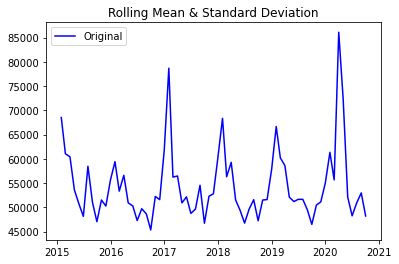

Results of Dickey-Fuller Test:
Test Statistic                 -1.305184
p-value                         0.626797
#Lags Used                     11.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
X is not stationary


In [28]:
test_stationarity(ts)

<h2>Autocorrelazione e Autocorrelazione Parziale

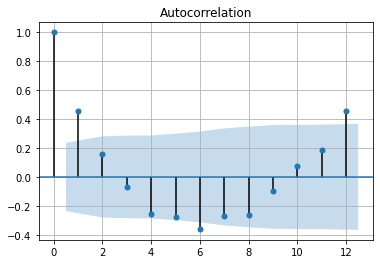

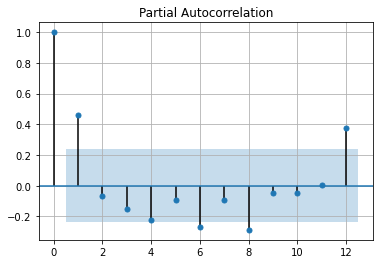

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plt.grid()
plot_pacf(ts, lags =12)
plt.grid()
plt.show()

<h2>Suddivisione della serie storica in train e test

Per poter costruire un modello predittivo è necessario suddividere la <b>serie storica </b> in `train` e `test`. 
<br />
La parte di `train`, che va dal <b>1 gennaio 2015</b> al <b>31 ottobre 2019</b>, sarà impiegata per l'allenamento del modello.
<br />
La parte di `test`, che va dal <b>1 novembre 2019</b> al <b>31 dicembre 2019</b>, sarà impiegata invece per testare la precisione di predizione del modello creato, andando a confrontare la predizione ottenuta con i valori originali della parte `test`.

In [30]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

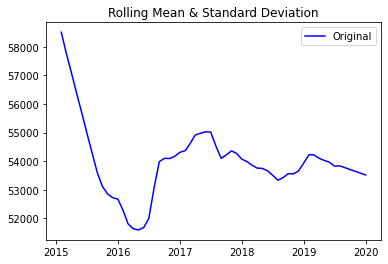

Results of Dickey-Fuller Test:
Test Statistic                 -4.801082
p-value                         0.000054
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64
X is stationary
0


In [31]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h1>CREAZIONE DEL MODELLO

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(12,1,1))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                 TOTALE   No. Observations:                   58
Model:              SARIMAX(12, 1, 1)   Log Likelihood                -572.554
Date:                Fri, 19 Mar 2021   AIC                           1173.107
Time:                        16:38:20   BIC                           1201.710
Sample:                    01-31-2015   HQIC                          1184.223
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5640      0.438     -1.287      0.198      -1.423       0.295
ar.L2         -0.2782      0.164     -1.696      0.090      -0.600       0.043
ar.L3         -0.3074      0.120     -2.569      0.0

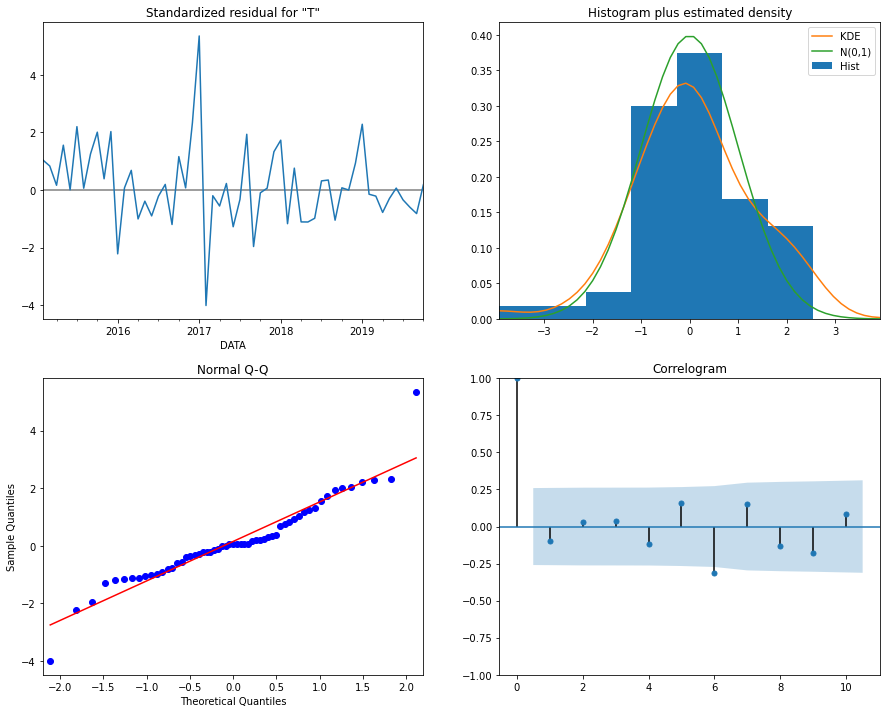

In [33]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

<h2>Verifica che i residui del modello siano stazionari

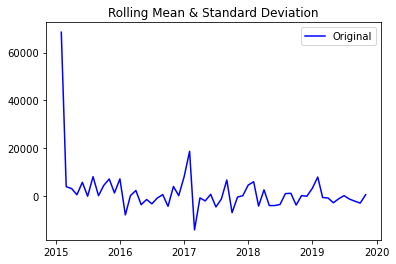

Results of Dickey-Fuller Test:
Test Statistic                -1.527237e+01
p-value                        4.697875e-28
#Lags Used                     0.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64
X is stationary


In [34]:
residuals = model_fit.resid
test_stationarity(residuals)

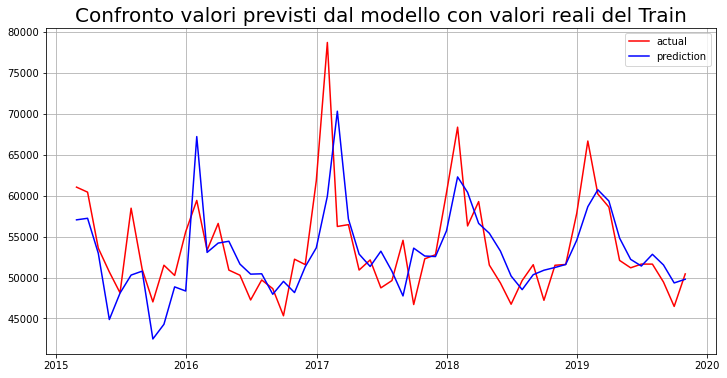

In [37]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='actual')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='prediction')
plt.legend()
plt.grid()
plt.show()

<h2>Intervallo di confidenza del modello

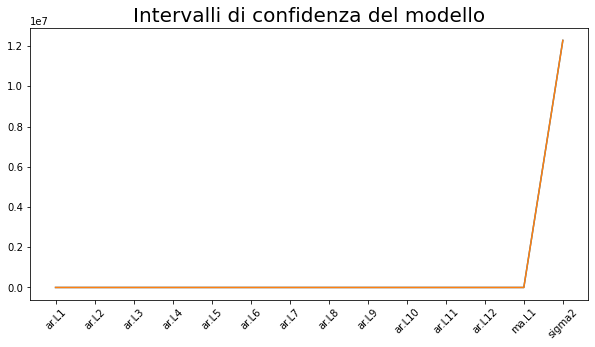

In [38]:
conf = model_fit.conf_int(alpha=0.05)
plt.figure(figsize=(10,5))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h2>Predizione del modello sul test

<h4>Inizio e fine della predizione del modello

In [39]:
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-30 00:00:00


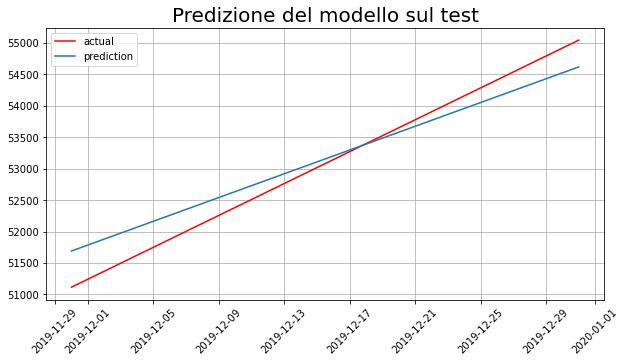

In [42]:
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(10,5))
plt.title('Predizione del modello sul test', size=20)
plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [43]:
# Accuracy metrics
import numpy as np
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE: errore percentuale medio assoluto
    me = np.mean(forecast - actual)             # ME: errore medio
    mae = np.mean(np.abs(forecast - actual))    # MAE: errore assoluto medio
    mpe = np.mean((forecast - actual)/actual)   # MPE: errore percentuale medio
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr: correlazione tra effettivo e previsione
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax: errore min-max
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions_test, test)

{'mape': 0.009503150762156708,
 'me': 74.31338636482906,
 'mae': 500.9811664608678,
 'mpe': 0.001751755876319218,
 'rmse': 506.46284023756385,
 'corr': 1.0,
 'minmax': 0.0094405192126783}

In [44]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('NRMSE: %f'% nrmse)

NRMSE: 0.128904


<h1>Predizione totale

<h4>Inizio e fine della predizione totale

In [45]:
start = ts.index[0]
end = ts.index[-1]


print(end)
print(start)

2020-09-30 00:00:00
2015-01-31 00:00:00


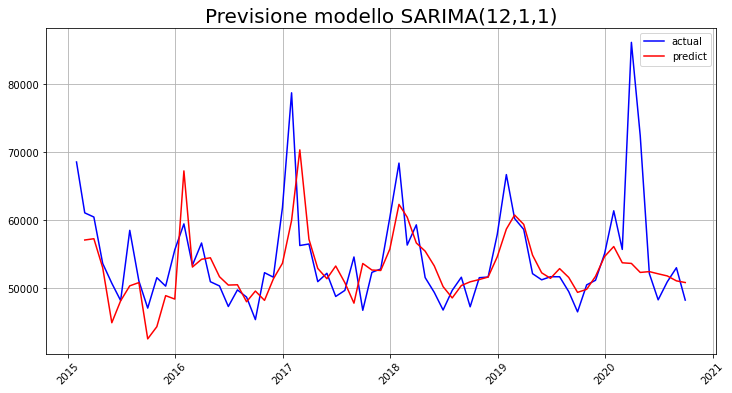

In [47]:
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)



plt.figure(figsize=(12,6))
plt.title('Previsione modello SARIMA(12,1,1)', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [56]:
import numpy as np
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE: errore percentuale medio assoluto
    me = np.mean(forecast - actual)             # ME: errore medio
    mae = np.mean(np.abs(forecast - actual))    # MAE: errore assoluto medio
    mpe = np.mean((forecast - actual)/actual)   # MPE: errore percentuale medio
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr: correlazione tra effettivo e previsione
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax: errore min-max
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions_tot, ts)

{'mape': 0.07910024815054148,
 'me': -2249.0069680873257,
 'mae': 4817.3538019337775,
 'mpe': -0.028749314021489916,
 'rmse': 10474.784214270578,
 'corr': 0.09644810072964426,
 'minmax': 0.07683664718532002}

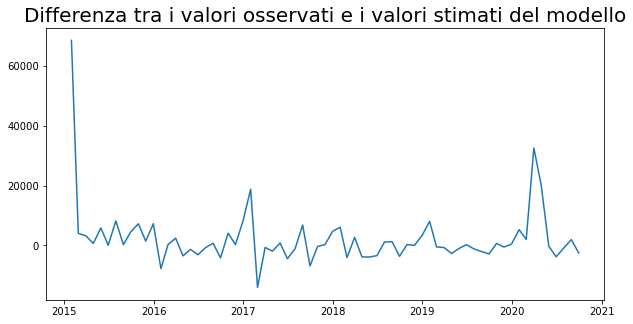

In [57]:
diff_predictions_tot = (ts - predictions_tot)

plt.figure(figsize=(10,5))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [58]:
predictions_tot.to_csv('../csv/predictions_SARIMA.csv')

In [59]:
diff_predictions_tot['24-02-2020':].sum()

48973.357940963986

<h1>Intervalli ci confidenza

In [60]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int(alpha=0.05)
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower TOTALE'])

2015-01-31        0.000000
2015-02-28    57038.363031
2015-03-31    57228.852168
2015-04-30    52965.883807
2015-05-31    44870.382307
                  ...     
2020-05-31    52388.766762
2020-06-30    52067.024313
2020-07-31    51754.370725
2020-08-31    51030.466831
2020-09-30    50784.691981
Freq: M, Name: predicted_mean, Length: 69, dtype: float64
            lower TOTALE  upper TOTALE
2015-01-31  -7874.703833   7874.703833
2015-02-28  49526.382899  64550.343163
2015-03-31  49748.008329  64709.696007
2015-04-30  45546.448711  60385.318904
2015-05-31  37569.125025  52171.639589
...                  ...           ...
2020-05-31  41824.442269  62953.091254
2020-06-30  41361.296868  62772.751758
2020-07-31  40968.578106  62540.163344
2020-08-31  40120.495777  61940.437884
2020-09-30  39698.974984  61870.408978

[69 rows x 2 columns]
2015-01-31     7874.703833
2015-02-28     7511.980132
2015-03-31     7480.843839
2015-04-30     7419.435097
2015-05-31     7301.257282
                  .

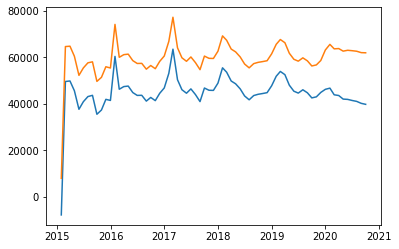

In [61]:
plt.plot(in_c)
plt.show()

In [62]:
upper = in_c['upper TOTALE']
lower = in_c['lower TOTALE']

In [63]:
lower.to_csv('../csv/predictions_SARIMA_lower.csv')
upper.to_csv('../csv/predictions_SARIMA_upper.csv')